(24, 200)


(-0.5, 199.5, 23.5, -0.5)

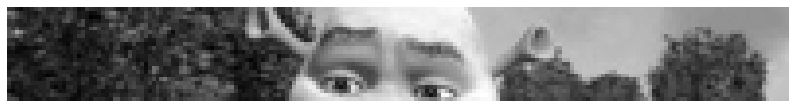

In [1]:
# Get image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

img0 = Image.open('res/shrek.png')
img0 = rgb2gray(np.array(img0).astype('float32')/255.)
print(img0.shape);
rx,cx = img0.shape

plt.figure(figsize=(14, 3));
plt.imshow(img0, 'gray')
plt.axis('off')

In [2]:
# Penalise second order derivative...

def GradientOrder(x, axis=0, order='first'):
    x = x if axis == 0 else x.T;
    if(order == 'first'):
        y=x-np.roll(x,1,axis=0)
        y[0,:]=0
    elif(order == 'second'):
        y=(1/4)*x-(1/2)*np.roll(x,1,axis=0)+(1/4)*np.roll(x,2,axis=0)
        y[1,:]=0;
        y[0,:]=0;
    return y if axis == 0 else y.T;

def DivOrder(x, axis=0, order='first'):
    x = x if axis == 0 else x.T;
    N = len(x);
    if(order == 'first'):
        y=x-np.roll(x,-1,axis=0)
        y[0,:]=-x[1,:]
        y[N-1,:]=x[N-1,:]
    elif(order == 'second'):
        y=(1/4)*x-(1/2)*np.roll(x,-1,axis=0)+(1/4)*np.roll(x,-2,axis=0)
        y[0,:]=(1/4)*x[2,:]
        y[1,:]=-(1/2)*x[2,:] + (1/4)*x[3,:]
        y[N-2,:]=-(1/2)*x[N-1,:] + (1/4)*x[N-2,:]
        y[N-1,:]=(1/4)*x[N-1,:]
    return y if axis == 0 else y.T;

# xt = param.lambda*[x(:,3:dim(2))/4 - x(:,2:dim(2)-1)/2 + x(:,1:dim(2)-2)/4,zeros(dim(1),2)];
#x = param.lambda*([y(:,1:1)/4,
#                   -y(:,1)/2 + y(:,2)/4, 
#                   y(:,3:dim(2)-2)/4 - y(:,2:dim(2)-3)/2 + y(:,1:dim(2)-4)/4,
#                   y(:,dim(2)-3)/4 - y(:,dim(2)-2)/2,
#                   y(:,dim(2)-2)/4]);

def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return np.asarray(y)
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x

def Prox_normL2_Ainpainting(x, tau, z, mask):
    return (x + mask * tau * z) / (np.ones(x.shape) + mask * tau);

def prox_L1(x, tau):
    return np.sign(x)*np.maximum(np.abs(x)-tau[:, None, None],0)


def ProjGradBouleInf(x,l,tau):
    # print(x.shape); (2, 24, 200) --> gradient... 
    temp = x - tau*prox_L1(x/tau, l/tau)
    return temp
    
def ChambollePockDenoisingTVinpainting(y,mask,lamb,tau,sigma,Niter):
    x_n = y # Init primal
    v_n = Gradient(x_n) # Init dual
    
    table_energy = 1e10*np.ones(Niter)
    for k in range(0,Niter):
        x_n = Prox_normL2_Ainpainting(x_n-tau*Div(v_n),tau,y, mask)
        y_n = 2*x_n-x_n
        v_n = ProjGradBouleInf(v_n+sigma*Gradient(y_n), lamb, sigma);
        grad = Gradient(x_n);
        table_energy[k] = 0.5*np.sum(mask*(y-x_n)**2)+np.sum(lamb[:, None, None]*np.abs(grad));
    x = x_n
    return x,table_energy

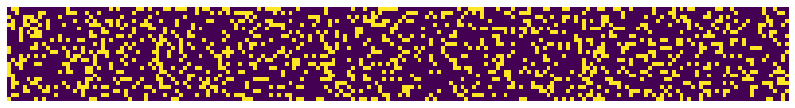

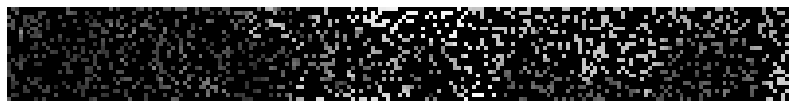

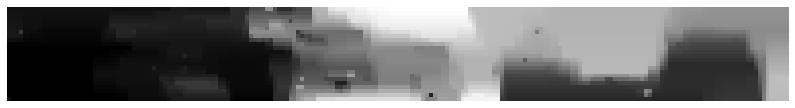

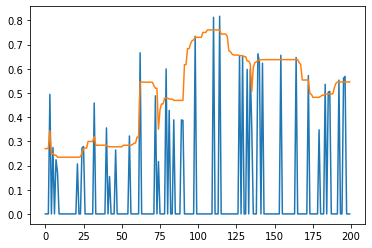

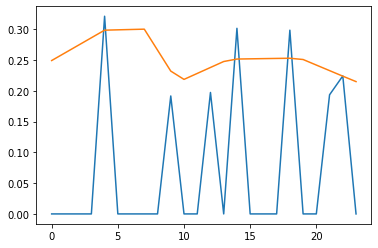

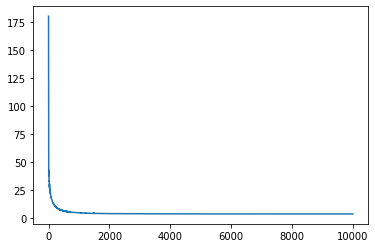

In [3]:
# Number of zero pixels... (Keep proportions)
random_mask = np.ones(img0.shape);
cells = [(i, j) for i in range(rx) for j in range(cx)];
zero_count = int(len(cells)*0.75);

# print(cells);

np.random.seed(1337);
for _ in range(zero_count):
    idx = np.random.randint(0, len(cells));
    random_mask[cells.pop(idx)] = 0;

plt.figure(figsize=(14, 3));
plt.imshow(random_mask);
plt.axis('off')


img0_masked = img0*random_mask;
plt.figure(figsize=(14, 3));
plt.imshow(img0_masked, 'gray');
plt.axis('off');

sigma = 0.05
tau = 0.99/(1 + 4*sigma);
# Modify order for Ver/Hor
def DivVer(x):
    return DivOrder(x, axis=0, order='second');
def DivHor(x):
    return DivOrder(x, axis=1, order='first');    
def GradientVer(x):
    return GradientOrder(x, axis=0, order='second');
def GradientHor(x):
    return GradientOrder(x, axis=1, order='first');
img0_cp, *_ = ChambollePockDenoisingTVinpainting(img0_masked, random_mask,
    lamb=np.array([0.05, 0.05]),
    tau=tau,sigma=sigma,Niter=10000)

plt.figure(figsize=(14, 3));
plt.imshow(img0_cp, 'gray');
plt.axis('off')

plt.figure();
plt.plot(img0_masked[6,:]);
plt.plot(img0_cp[6,:]);

plt.figure();
plt.plot(img0_masked[:,30]);
plt.plot(img0_cp[:,30]);

plt.figure()
plt.plot(_[0])